# Machine Learning Model to Segment Customers and Predict Customer Outcomes.
The goal of this model is to segment customers based on features that are most relevant to predicting customer outcomes, and then predicting these outcomes. The generated segments can then be used to re-partition the database (if necessary). Customer outcomes are the buying and selling of a product being marketed to them.

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
# from sklearn.pipeline import make_pipeline

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from umap import UMAP

# Dataset Preprocessing


## Loading the dataset
- Discrete and continuous (categorical and numerical) features are differentiated for convenience

n=

In [108]:
discrete_features = []

continuous_features = []

features = discrete_features + continuous_features

labels = []
df = pd.read_excel('', usecols=features+labels)
df = df.dropna()

# Sanity check
print('Dataset shape',df.shape)

# #Find the columns with most null values
# for column in df.columns:
#     if df[column].isnull().sum() > 0:
#         print(column, df[column].isnull().sum())

Dataset shape (136, 19)


## Splitting the dataset

Training dataset: n=
Validation dataset: n=

In [110]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[labels], test_size=0.25, random_state=42, stratify=df[labels])

# Sanity check
print('Training data shape',X_train.shape)
print('Testing data shape',X_test.shape)

Training data shape (102, 18)
Testing data shape (34, 18)


# Data Pipeline

# Preprocessing

### Encoding

In [ ]:
encoder = ColumnTransformer(transformers=[('encoder', OrdinalEncoder(), discrete_features)], remainder='passthrough')

### Scaling

In [ ]:
scaler = ColumnTransformer(transformers=[('scaler', StandardScaler(), continuous_features)], remainder='passthrough')

### Oversampling

In [111]:
ros = RandomOverSampler(random_state=42)

## Model Selection
Since the data set is relatively small and sparse, an SVM would be an ideal model. Other models, including a neural network, were attempted unsuccessfully. A polynomial kernel was decided upon by trial and error, and 5 k-fold cross validation was done throughout the training process to mitigate over fitting.

- https://www.baeldung.com/cs/svm-vs-neural-network

In [112]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = SVC(kernel='poly')

# Sanity check: 5 fold cross validation of model on training data
scores_training = cross_val_score(model, X_train, y_train.values.ravel(), cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_training.mean(), scores_training.std()))

0.61 accuracy with a standard deviation of 0.05


## Feature Engineering
Feature engineering is done on the training dataset and validated using K-fold cross-validation to combat overfitting.

The sequential feature selection algorithm is used in the forward direction in order to favor fewer features (to combat overfitting and simplify the model).

- https://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

The UMAP algorithm is used for feature extraction. The UMAP parameters are tuned automatically.

- https://umap-learn.readthedocs.io/en/latest/how_umap_works.html
- https://arxiv.org/abs/1802.0342


In [113]:
sfs = SFS(
        estimator=model,
        forward=True,
        floating=True,
        verbose=0,
        scoring='accuracy',
        cv=stratified_kfold)

umap = UMAP(random_state=42)

## Hyperparameter Tuning

All the data-sensitive preprocessing and feature engineering are encapsulated in a pipeline to simplify the enforcement of best practices and avoid data leakage. Hyperparameter tuning is done with the halving grid search algorithm, and the initial conditions for the parameter grid were determined by trial and error.

- https://doi.org/10.3390/electronics10161973

In [114]:
pipe = Pipeline(steps=[
    ('encoder', encoder),
    ('scaler', scaler),
    ('ros', ros),
    ('sfs', sfs),
    ('umap', umap),
    ('model', model)
])

param_grid = {"umap__n_components": [2, 3, 4],
              "umap__n_neighbors": [7, 8, 9],}

hgs = HalvingGridSearchCV(
    estimator=pipe,
    param_grid=param_grid, 
    cv=stratified_kfold, 
    scoring='accuracy',
    verbose=1,
    refit=True, 
    n_jobs=1)

## Training

In [115]:
hgs.fit(X_train, y_train.values.ravel())

n_iterations: 2
n_required_iterations: 3
n_possible_iterations: 2
min_resources_: 20
max_resources_: 102
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 20
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 3
n_resources: 60
Fitting 5 folds for each of 3 candidates, totalling 15 fits


HalvingGridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                    estimator=Pipeline(steps=[('scaler',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('scaler',
                                                                                StandardScaler(),
                                                                                ['tumor_size_diameter',
                                                                                 'tumor_volume'])])),
                                              ('ros',
                                               RandomOverSampler(random_state=42)),
                                              ('umap', UMAP(random_state=42)),
                                              ('model', SVC(kernel='poly'))]),
                    n_jobs=1,
                    param_grid={'umap__n_components': [2, 3, 4],
                                'umap__n_neighbors': [7, 8, 9]},
                    scoring='accuracy', verbose=1)

In [116]:
# print the best features
# print(hgs.best_estimator_.named_steps['sfs'].k_feature_idx_)
# print the best parameters
print("HGS params", hgs.best_params_)

# print the best score
print("HGS score", hgs.best_score_)

HGS params {'umap__n_components': 3, 'umap__n_neighbors': 8}
HGS score 0.5621212121212121


In [117]:
# fs_metric_dict = hgs.best_estimator_.named_steps['sfs'].get_metric_dict(confidence_interval=0.95)
# fig_fs_metric = plot_sfs(fs_metric_dict, kind='std_dev')
# plt.grid()
# plt.show()
# df_fs_metric = pd.DataFrame.from_dict(fs_metric_dict).T
# df_fs_metric

# Model evaluation

In [119]:
y_pred = hgs.predict(X_test)

## ROC
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds.

- https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

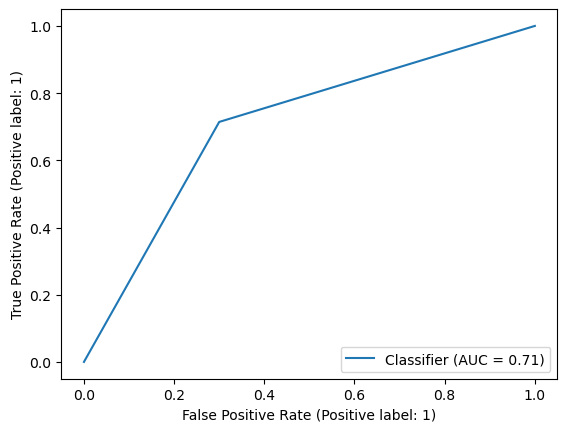

In [120]:
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()

## Confusion matrix and classification report

- https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62

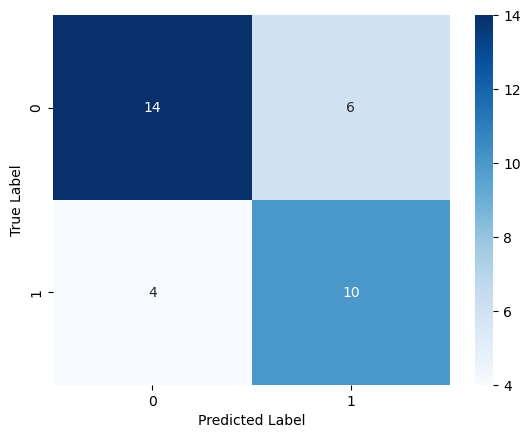

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        20
           1       0.62      0.71      0.67        14

    accuracy                           0.71        34
   macro avg       0.70      0.71      0.70        34
weighted avg       0.71      0.71      0.71        34



In [121]:
cm = confusion_matrix(y_test, y_pred)

cm_matrix = pd.DataFrame(data=cm)

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues').set(xlabel='Predicted Label', ylabel='True Label')

plt.show()
print(classification_report(y_test, y_pred, zero_division=0))